# Exploration of Attention Mechanisms

The goal of this notebook is to provide some dummy examples demonstrating the workings of different attention mechanisms in practice.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

# Seed rng
seed = 365
np.random.seed(seed)

/home/florsanders/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Bahdanau Attention

This is the attention mechanisms originally proposed in [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473).

Starting from the hidden states:
- Of the encoder: $h_j$, $j \in \{1, T_h\}$
- Of the decoder, right-shifted: $s_{i-1}$, $i \in \{2, T_s\}$

Energies are computed by means of a 2 layer dense network with a hidden $\tanh$ activation function, and subsequently normalized using softmax.

- $e_{ij} = v_a^{\top} \cdot \tanh{ \left( W_a \cdot s_{i-1} + U_a \cdot h_j \right) }$

- $\alpha_{ij} = \text{softmax}(e_{ij})$

Where $v_a$, $W_a$ and $U_a$ are learned parameters.

Finally, the normalized energies are used as weights to compute the decoder context vectors.

- $c_i = \sum_{j}{\alpha_{ij} h_j}$

In [2]:
# Parameters
dim_h = 8 # Dimension of the encoder states h_j (2n)
dim_s = 8 # Dimension of the decoder states s_i (n)
T_h = 5 # Length of the encoder sequence
T_s = 5 # Length of the decoder sequence

dim_i = min(dim_h, dim_s) # Intermediate dimension of the weight matrices

In [3]:
# Generate hidden states
h = np.random.randint(0, 2, (T_h, dim_h)).astype(float)
s = np.random.randint(0, 2, (T_s, dim_s)).astype(float)

print("Encoder states h:\n", h)
print("Decoder states s:\n", s)

Encoder states h:
 [[0. 0. 1. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 1.]
 [0. 1. 1. 1. 1. 0. 0. 1.]
 [0. 1. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0.]]
Decoder states s:
 [[1. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1. 0. 1. 1.]
 [1. 1. 0. 0. 0. 1. 1. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]


In [4]:
# Generate weight matrices
W = np.random.randint(0, 2, (dim_i, dim_s)).astype(float)
U = np.random.randint(0, 2, (dim_i, dim_h)).astype(float)
v = np.random.randint(0, 2, (1, dim_i)).astype(float)

print(f"W: \n", W)
print(f"U: \n", U)
print(f"v: \n", v)

W: 
 [[0. 1. 0. 1. 1. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 1. 0.]
 [1. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 1. 0. 1.]]
U: 
 [[1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 1. 0.]
 [1. 0. 1. 1. 1. 1. 1. 0.]
 [1. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 1. 1.]]
v: 
 [[0. 0. 0. 0. 0. 1. 1. 0.]]


In [5]:
# Initialize energies
e = np.zeros((T_s, T_h))

# For every output token
for i in range(T_s):
    # Right-shift s
    if i == 0:
        s_i = np.zeros(dim_s)
    else:
        s_i = s[i-1]

    # For every input token
    for j in range(T_h):
        # Compute energy
        W_dot_s = np.matmul(W, s_i)
        U_dot_h = np.matmul(U, h[j])
        e_ij = np.matmul(v, np.tanh(W_dot_s + U_dot_h))
        e[i, j] = np.squeeze(e_ij)

print("Energies: \n", e)

Energies: 
 [[1.75664891 0.96402758 1.95908233 1.95908233 0.96402758]
 [1.96401529 1.99010951 1.99504247 1.99504247 1.76150336]
 [1.99496396 1.96335688 1.9992385  1.9992385  1.96335688]
 [1.99990754 1.99931701 1.99998605 1.99998605 1.99931701]
 [1.99505309 1.9986586  1.99932764 1.99932764 1.96401529]]


In [6]:
# Normalize energies to obtain weights
alpha = softmax(e, axis=1)

print("Weights: \n", alpha)

Weights: 
 [[0.22967014 0.10396172 0.2812032  0.2812032  0.10396172]
 [0.20382617 0.20921485 0.21024945 0.21024945 0.16646009]
 [0.20216961 0.19587955 0.20303564 0.20303564 0.19587955]
 [0.20004096 0.19992286 0.20005666 0.20005666 0.19992286]
 [0.20073798 0.20146305 0.20159788 0.20159788 0.19460321]]


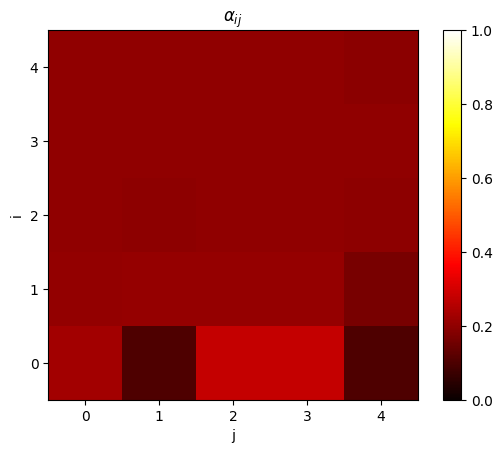

In [7]:
# visualize weights
fig, ax = plt.subplots()
im = ax.imshow(alpha, cmap="hot", vmin=0, vmax=1, interpolation="none", origin="lower")
fig.colorbar(im)
ax.set_xlabel("j")
ax.set_ylabel("i")
ax.set_title(r"$\alpha_{ij}$")
plt.show()

With random vectors, the distribution of attention is approximately uniform.

In [8]:
# Compute context vectors
c = np.matmul(alpha, h)
print("Context vectors: \n", c)

Context vectors: 
 [[0.10396172 0.56240641 0.79207655 0.61483507 0.56240641 0.61483507
  0.10396172 0.38516493]
 [0.20921485 0.4204989  0.62432506 0.5805357  0.4204989  0.5805357
  0.20921485 0.4194643 ]
 [0.19587955 0.40607129 0.6082409  0.60108481 0.40607129 0.60108481
  0.19587955 0.39891519]
 [0.19992286 0.40011332 0.60015428 0.60002048 0.40011332 0.60002048
  0.19992286 0.39997952]
 [0.20146305 0.40319576 0.60393374 0.59693907 0.40319576 0.59693907
  0.20146305 0.40306093]]


## Scaled Dot-Product Attention

The scaled dot-product attention, as introduced in [Attention Is All You Need](https://arxiv.org/abs/1706.03762) is another way to compute the attention, based on the Query-Key-Value paradigm.

The Query and Key are used to compute a score, which aftern normalization is used to scale the values.

In this case, the full equation is:  
$\text{attention} = \text{softmax}{\left( \frac{Q \cdot K^\top}{\sqrt{d_k}} \right)} V$

In [9]:
# Initialize Q, K & V as interpreted from Badhanau attention
Q = s
K = h
V = h

d_k = dim_i

print(s.shape)
print(h.shape)

(5, 8)
(5, 8)


In [10]:
# Compute scores
e = np.matmul(Q, np.transpose(K))

print("Scores: \n", e)

Scores: 
 [[2. 2. 3. 2. 2.]
 [2. 0. 3. 3. 2.]
 [1. 3. 4. 3. 0.]
 [1. 3. 2. 2. 1.]
 [2. 1. 3. 3. 1.]]


In [11]:
# Normalize scores to obtain weights
alpha = softmax(e, axis=1)

print("Weights: \n", alpha)

Weights: 
 [[0.14884758 0.14884758 0.40460968 0.14884758 0.14884758]
 [0.13206727 0.01787336 0.35899605 0.35899605 0.13206727]
 [0.02760027 0.20393995 0.55436626 0.20393995 0.01015357]
 [0.06745081 0.49839779 0.1833503  0.1833503  0.06745081]
 [0.13942485 0.05129154 0.37899604 0.37899604 0.05129154]]


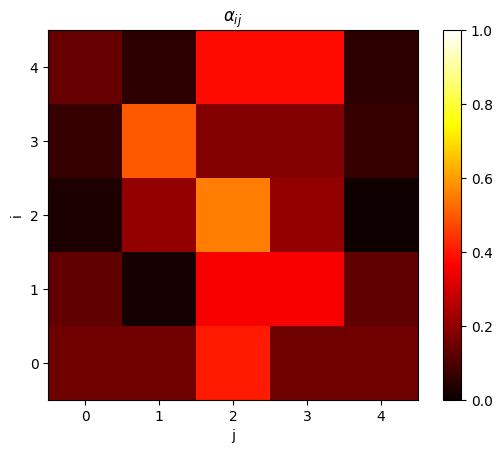

In [12]:
# visualize weights
fig, ax = plt.subplots()
im = ax.imshow(alpha, cmap="hot", vmin=0, vmax=1, interpolation="none", origin="lower")
fig.colorbar(im)
ax.set_xlabel("j")
ax.set_ylabel("i")
ax.set_title(r"$\alpha_{ij}$")
plt.show()

The effect of this multiplicative attention mechanism is signficantly more pronounced for the case of random vectors.

In [13]:
# Compute context vectors
c = np.matmul(alpha, h)
print("Context vectors: \n", c)

Context vectors: 
 [[0.14884758 0.55345726 0.70230484 0.70230484 0.55345726 0.44654274
  0.14884758 0.55345726]
 [0.01787336 0.7179921  0.85005937 0.62313059 0.7179921  0.62313059
  0.01787336 0.37686941]
 [0.20393995 0.75830621 0.78590648 0.5921201  0.75830621 0.24169379
  0.20393995 0.75830621]
 [0.49839779 0.3667006  0.43415141 0.31825191 0.3667006  0.31825191
  0.49839779 0.68174809]
 [0.05129154 0.75799208 0.89741693 0.56971243 0.75799208 0.56971243
  0.05129154 0.43028757]]
